In [12]:
import pandas as pd
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from langchain_openai import OpenAIEmbeddings
import shap
from nltk.corpus import stopwords
import string

In [2]:
df = pd.read_excel("FinalDementia2021Taxonomy_4DEC2023.xlsx", sheet_name="Data")
df

In [3]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation+string.digits))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [4]:
df['Log Details'] = df['Log Details'].apply(clean_text)

In [5]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Log Details'])
y = df['Based on log details, this case involves a patient with dementia'].astype(int)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [8]:
y_pred = model.predict(X)

In [9]:
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)

C:\Users\pouri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pouri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pouri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.8592964824120602
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.86      1.00      0.92       171

    accuracy                           0.86       199
   macro avg       0.43      0.50      0.46       199
weighted avg       0.74      0.86      0.79       199



In [18]:
# Compute the confusion matrix
cm = confusion_matrix(y, y_pred)

# Extract True Negatives (TN), False Positives (FP), False Negatives (FN), True Positives (TP)
TN, FP, FN, TP = cm.ravel()

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Explain each term
print("\nItems in the Confusion Matrix:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Identify False Positives and False Negatives
false_positives = [i for i, (true, pred) in enumerate(zip(y, y_pred)) if true == 0 and pred == 1]
false_negatives = [i for i, (true, pred) in enumerate(zip(y, y_pred)) if true == 1 and pred == 0]

print("\nIndices of False Positives:", false_positives)
print("Indices of False Negatives:", false_negatives)


Confusion Matrix:
[[  0  28]
 [  0 171]]

Items in the Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 28
False Negatives (FN): 0
True Positives (TP): 171

Indices of False Positives: [53, 57, 58, 73, 76, 102, 108, 111, 126, 128, 134, 140, 143, 151, 157, 158, 160, 164, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198]
Indices of False Negatives: []


In [11]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

C:\Users\pouri\anaconda3\lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [12]:
shap.initjs()

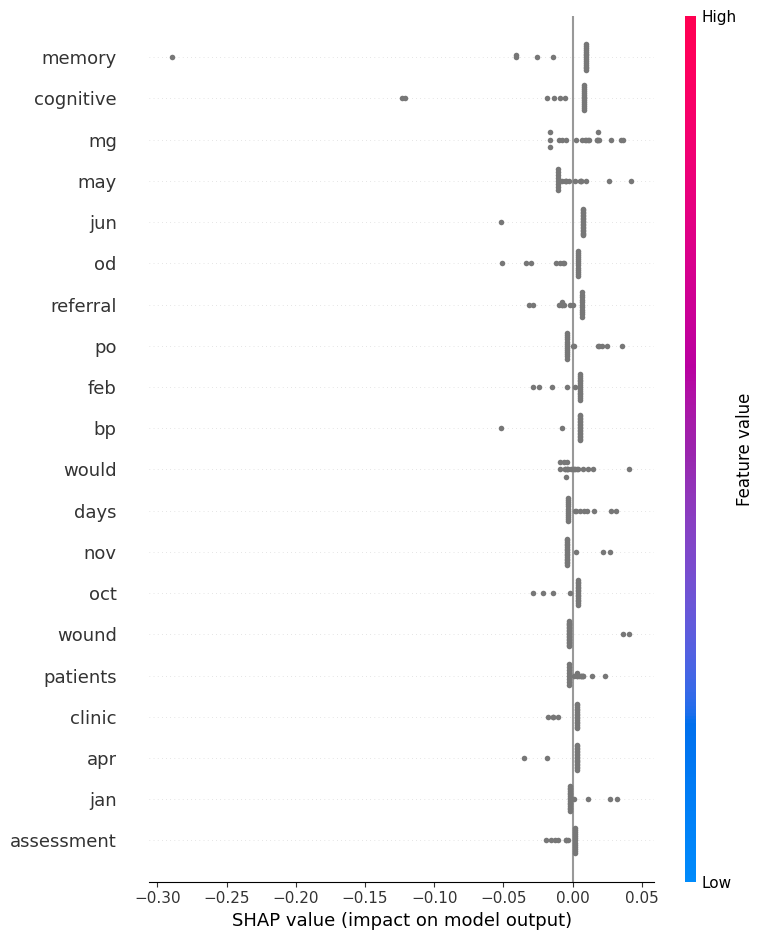

In [13]:
shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out())

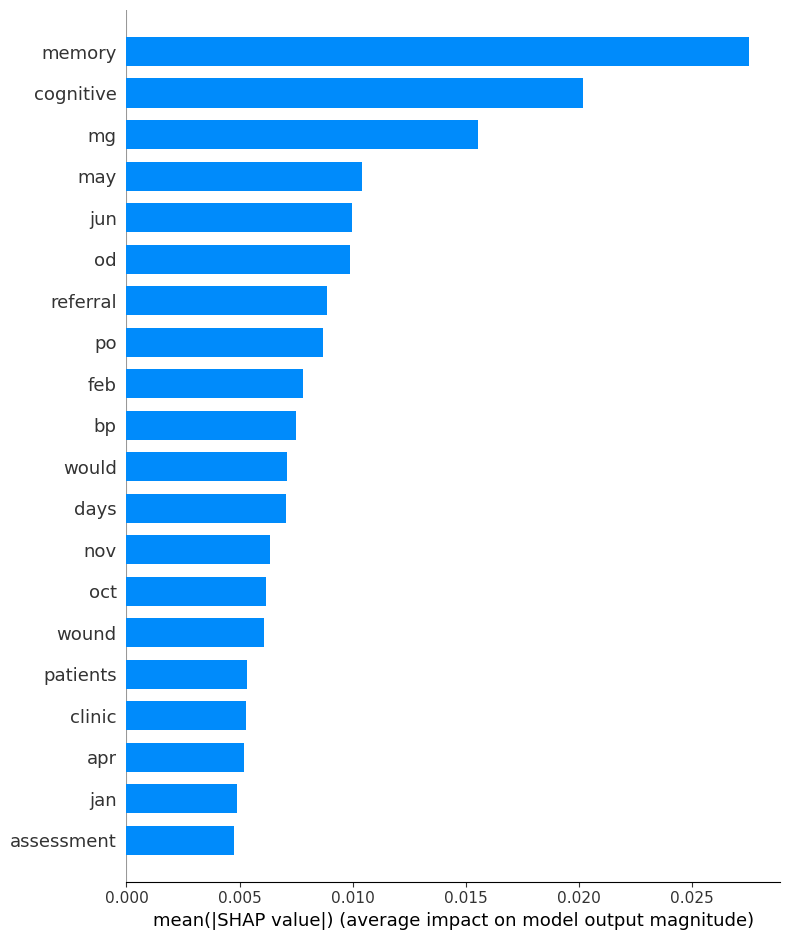

In [30]:
shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out(), plot_type="bar")

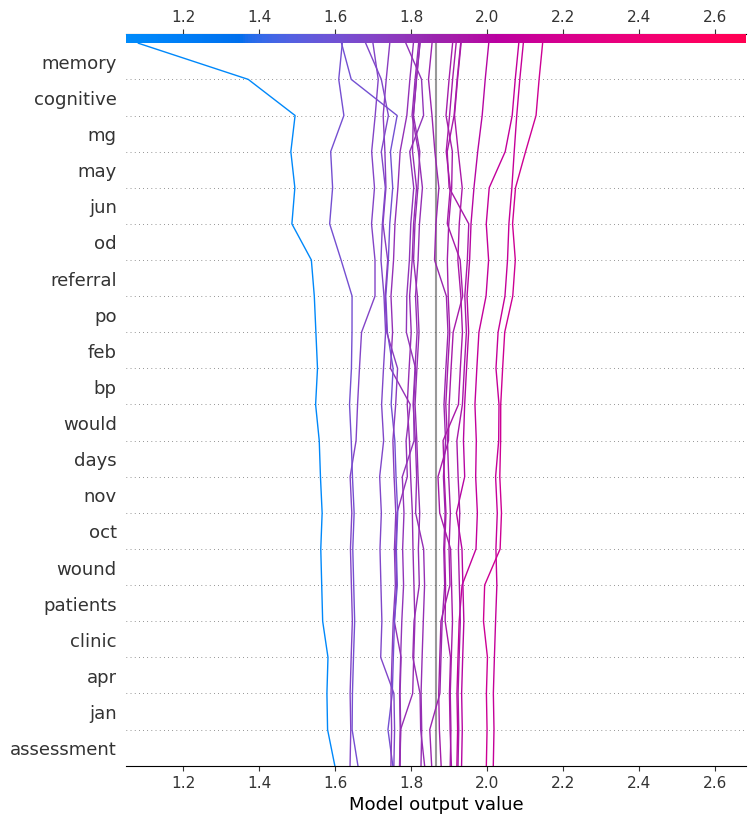

In [31]:
shap.decision_plot(explainer.expected_value, shap_values, X_test.toarray(), feature_names=vectorizer.get_feature_names_out())

In [32]:
shap.force_plot(explainer.expected_value, shap_values[0], features=X_test[0].toarray(), feature_names=vectorizer.get_feature_names_out())


In [33]:
#

In [121]:
df = pd.read_excel("FinalDementia_11APR2023_v2.xlsx", sheet_name="Final")
df.head(1)

,Form ID,Lookup Terms,Dementia Diagnosis,Dementia Diagnosis Refined,Log Details,Pt Age,Pt Gender,Specialty,Iterations,Urban/Rural Flag,LTC PCP Flag,LTC Text Flag,LTC Identification Final,LTC Identification Refined
0,014a2369-a49a-41d1-8f26-78ecd69d0c42,Dementia/Alz,1,1,31-Mar-2021 13:17 (Log Summary): (PCP Entry) P...,73.849463,Female,Neurology,1,Rural,0,1,NO,2


In [122]:
df['Log Details'] = df['Log Details'].apply(clean_text)

In [123]:
def label_value(x):
    if x == 1 or x == 'YES':
        return 1
    elif x in [2, 3, 4, 5, 6, 8] or x == 'NO':
        return 0
    else:
        return x


df['Dementia Diagnosis Modified'] = df['Dementia Diagnosis'].apply(label_value)

In [124]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Log Details'])
y = df['Dementia Diagnosis Modified'].astype(int)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [126]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [127]:
set(y)

{0, 1}

In [128]:
y_pred = model.predict(X)

In [129]:
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.8568507157464212
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78       187
           1       0.82      0.99      0.89       302

    accuracy                           0.86       489
   macro avg       0.89      0.82      0.84       489
weighted avg       0.88      0.86      0.85       489



In [130]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

C:\Users\pouri\anaconda3\envs\langchain_env\Lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


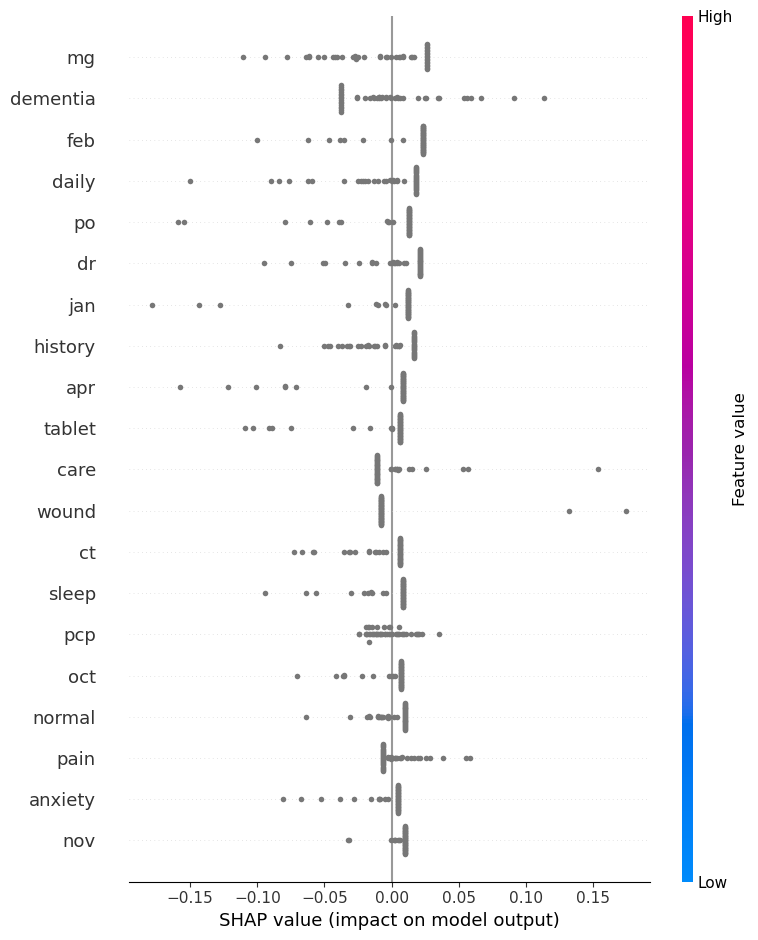

In [131]:
shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out())

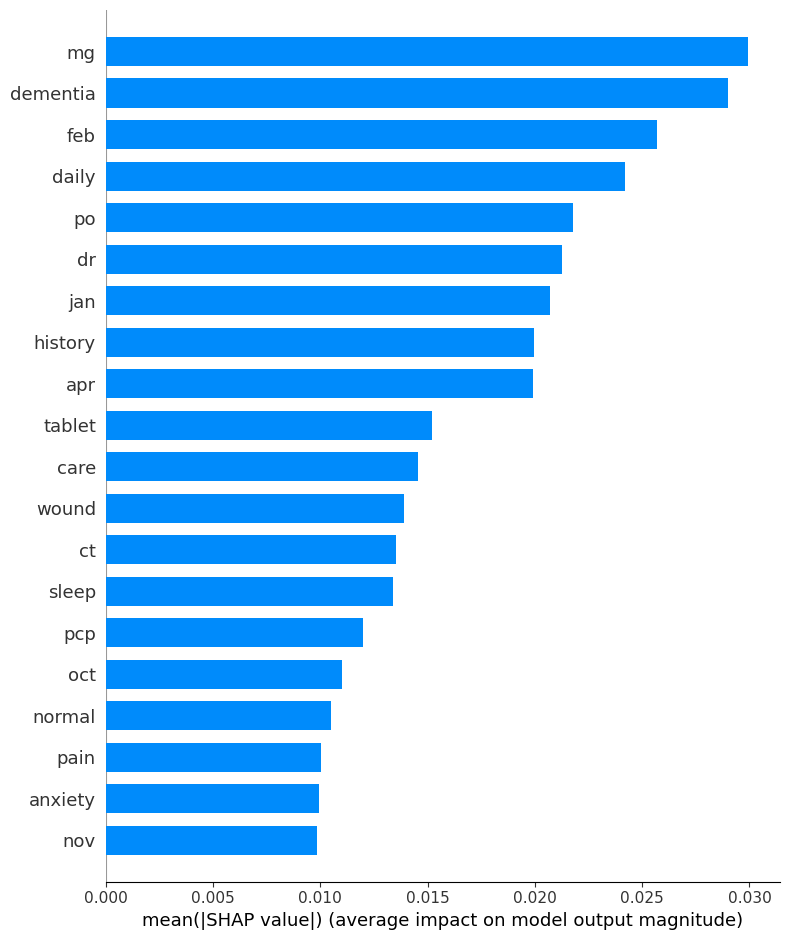

In [132]:
shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out(), plot_type="bar")

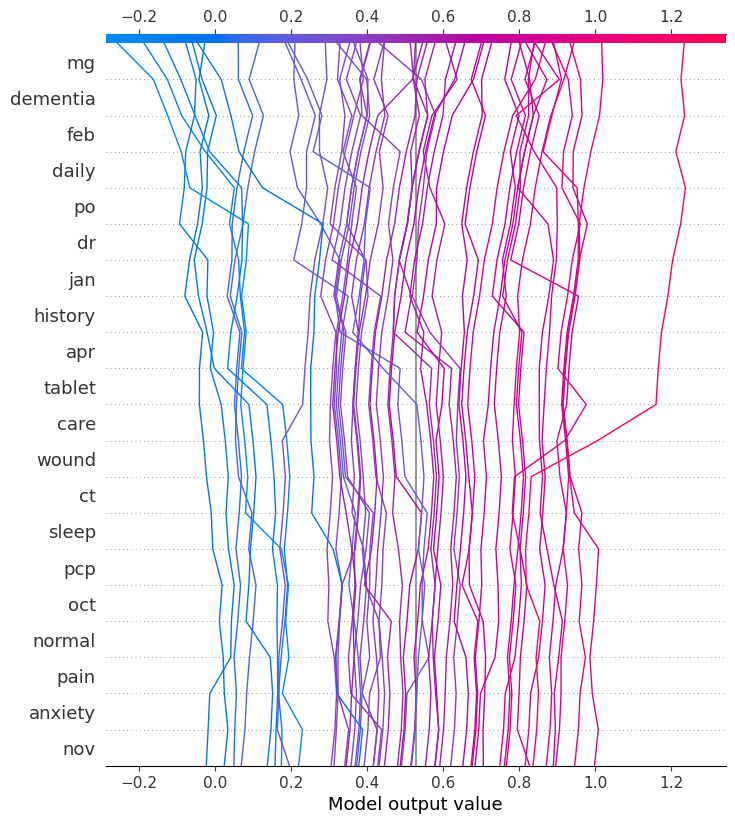

In [133]:
shap.decision_plot(explainer.expected_value, shap_values, X_test.toarray(), feature_names=vectorizer.get_feature_names_out())